In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import cv2

In [2]:
image = mpimg.imread('test.jpg')
type(image),image.shape

(numpy.ndarray, (720, 1280, 3))

In [3]:
ysize = image.shape[0]
xsize = image.shape[1]

## 提取斑马线

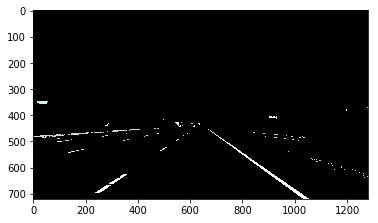

In [4]:
color_select = np.copy(image)

red_threshold = 200
green_threshold = 200
blue_threshold = 200
rgb_threshold = [red_threshold, green_threshold, blue_threshold]

# \表示连接上下两句，|表示或.
# !!图片的左上角是(0,0)原点
color_thresholds = (image[:,:,0] < rgb_threshold[0]) \
            | (image[:,:,1] < rgb_threshold[1]) \
            | (image[:,:,2] < rgb_threshold[2])
color_select[color_thresholds] = [0,0,0]

plt.imshow(color_select)
plt.show()

## 框选出斑马线在的区域，目的是去除提取斑马线时周边一些不必要的点

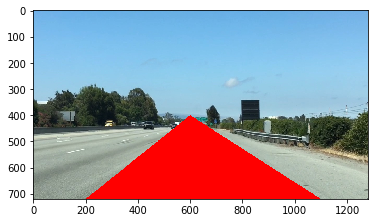

In [5]:
region_select = np.copy(image)

left_bottom = [200, 720]
right_bottom = [1100, 720]
apex = [600, 400]

# polyfit返回两点构成直线的AB,后面的1表示一次拟合
fit_left = np.polyfit([apex[0],left_bottom[0]],[apex[1],left_bottom[1]],1)
fit_right = np.polyfit([apex[0],right_bottom[0]],[apex[1],right_bottom[1]],1)
fit_bottom = np.polyfit([left_bottom[0],right_bottom[0]],[left_bottom[1],right_bottom[1]],1)

XX, YY = np.meshgrid(np.arange(0, xsize), np.arange(0, ysize))

region_thresholds = ( YY > (fit_left[0]*XX+fit_left[1])) \
            & (YY > (fit_right[0]*XX+fit_right[1])) \
            & (YY < (fit_bottom[0]*XX+fit_bottom[1]))

region_select[region_thresholds] = [255,0,0]

plt.imshow(region_select)
plt.show()

## 将上面两步结合，提取斑马线

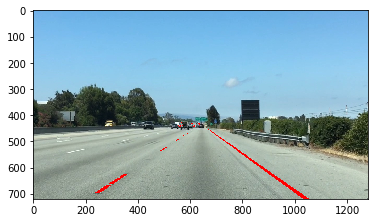

In [6]:
line_image = np.copy(image)
line_image[~color_thresholds & region_thresholds] = [255,0,0]

plt.imshow(line_image)
plt.show()

## 考虑光线等原因，斑马线不能由前面的方法提取，因此考虑根据形状来提取斑马线（直线）

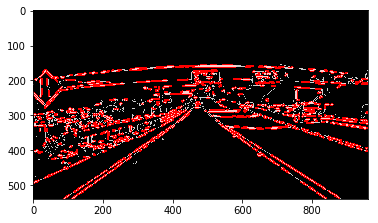

In [26]:
image = mpimg.imread('exit-ramp.jpg')
gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)

# gaussian smooth
kernel_size=3
blur_gray = cv2.GaussianBlur(gray,(kernel_size, kernel_size), 0)

# find edge according to gradient;return a binary image
low_threshold = 50
high_threshold = 150
edges = cv2.Canny(blur_gray, low_threshold, high_threshold)

# create a empty image
line_image = np.copy(image)*0

# Hough transform to find the line;return the endpoints (x1, y1, x2, y2)(直线中的两个点) 
rho = 1
theta = np.pi/180
threshold = 1
min_line_length = 5
max_line_gap = 1
lines = cv2.HoughLinesP(edges, rho, theta, threshold, np.array([]),min_line_length, max_line_gap)

# output the line in image；5 in line decide the width of line
for line in lines:
    for x1,y1,x2,y2 in line:
        cv2.line(line_image,(x1,y1),(x2,y2),(255,0,0),5)

# edges.shape = (540, 960), color_edges.shape=(540, 960,3)--RGB
color_edges = np.dstack((edges, edges, edges)) 

# 
combo = cv2.addWeighted(color_edges, 0.8, line_image, 1, 0) 

plt.imshow(combo)
plt.show()